In [1]:
import random
import os
import pathlib

import matplotlib.pyplot as plt
import cv2
# from skimage.morphology import erosion, dilation

import train
import config
from model import losses
from train import make_datasets


In [2]:
ds_root = pathlib.Path('/dataset/valid/')
pathlist = (ds_root/'map').glob("*.png")

pathlist = [path.name for path in pathlist]
random.shuffle(pathlist)

# テストのため1/4のデータでやってみる
nb_tr = int(len(pathlist) * 0.8)
nb_va = int(len(pathlist) * 0.2)
tr_pathlist = pathlist[:nb_tr]
va_pathlist = pathlist[nb_tr:]

train_ds, _ = make_datasets(
    ds_root=ds_root,
    tr_path=tr_pathlist,
    va_path=va_pathlist,
    use_cutmix=False,
)



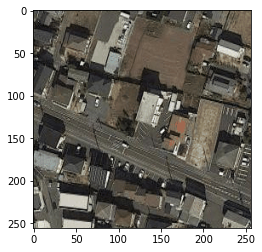

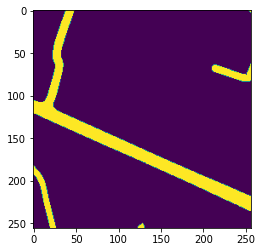

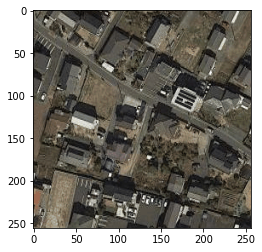

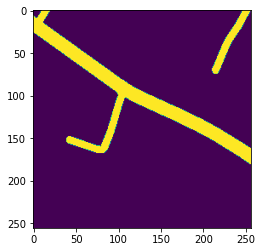

In [3]:
for i, t in train_ds.take(2):
    plt.imshow(i[0])
    plt.show()
    plt.imshow(t[0])
    plt.show()

In [5]:
# model.load_weights("/results/211126/checkpoints/cmTn3-a7-E200/cmTn3-a7-E200")
modelname = "/fttest"
modelpath = "/results/211206/checkpoints" + modelname + modelname

loss = losses.TverskyLoss(name="Tversky", alpha=0.7)
model = train.compile_model(loss=loss)
ret = model.load_weights(modelpath)


In [5]:

# 訓練
model_history = model.fit(
    train_ds,
    epochs=args["epochs"],
    validation_data=valid_ds,
    steps_per_epoch=config.STEPS_PER_EPOCH,
    validation_steps=1,
    # callbacks=get_callbacks(args["logdir"]),
)


Epoch 1/2
133/133 [==============================] - 87s 588ms/step - loss: 0.3642 - mean_io_u: 0.6283 - val_loss: 0.3882 - val_mean_io_u: 0.6056
Epoch 2/2
133/133 [==============================] - 77s 581ms/step - loss: 0.2956 - mean_io_u: 0.6610 - val_loss: 0.3518 - val_mean_io_u: 0.6502


dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])


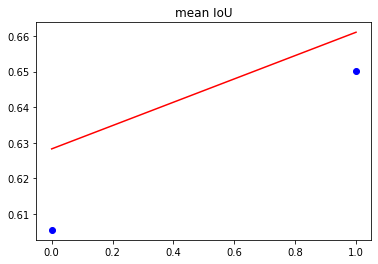

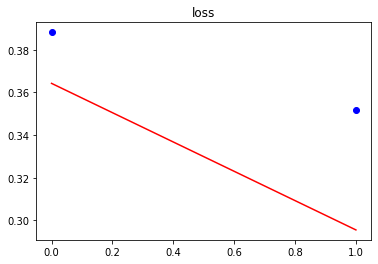

In [6]:
print(model_history.history.keys())
tr_loss = model_history.history["loss"]
va_loss = model_history.history["val_loss"]
tr_iou = model_history.history["mean_io_u"]
va_iou = model_history.history["val_mean_io_u"]

plt.figure()
plt.title("mean IoU")
plt.plot(tr_iou, "r")
plt.plot(va_iou, "bo")
plt.show()

plt.title("loss")
plt.plot(tr_loss, "r")
plt.plot(va_loss, "bo")
plt.show()


/mass_roads/test/sat/16.png


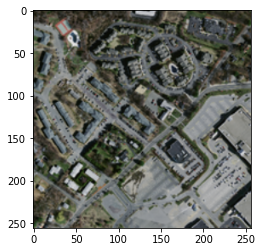

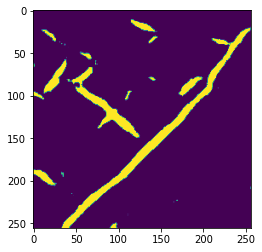

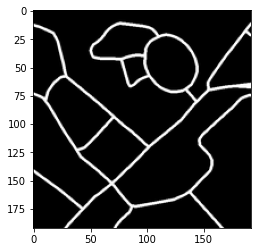

In [6]:
basepath = config.VA_SAT_PATH
random.seed(1)
path = random.sample(list(basepath.glob("*.png")), 1)[0].name

sat_im = cv2.imread(str(basepath / path))[:, :, ::-1] / 255.0
sat_im = cv2.resize(sat_im, dsize=(256, 256))
map_im = cv2.imread(str(config.VA_MAP_PATH / path))[:, :, ::-1]

print(str(basepath / path))

plt.imshow(sat_im)
plt.show()
pred = model.predict(sat_im[None])
plt.imshow((pred[0][:, :, 0]))
plt.show()
plt.imshow(map_im)
plt.show()


(64, 256, 256, 3)
(64, 256, 256, 1)


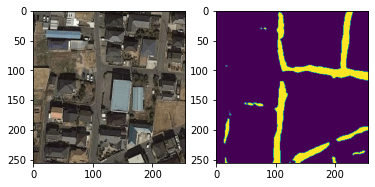

(64, 256, 256, 3)
(64, 256, 256, 1)


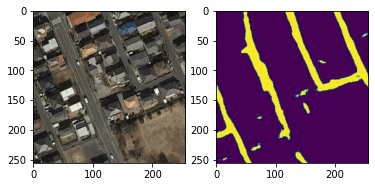

(64, 256, 256, 3)
(64, 256, 256, 1)


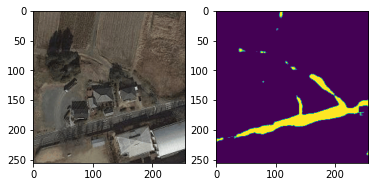

In [9]:
for i,t in train_ds.take(3):
    print(i.shape)
    print(t.shape)
    pred = model.predict(i)
    plt.subplot(1,2,1)
    plt.imshow(i[0])
    plt.subplot(1,2,2)
    plt.imshow(pred[0])
    plt.show()